# Implémentation de U-Net avec Keras

U-Net est une architecture très utilisée pour la segmentation. 

Cette architecture est à la fois efficace, et simple à implémenter. 

Dans ce notebook, nous allons implémenter un réseau de segmentation U-Net pour réaliser la segmentation sémantique sur le jeu de données *Oxford-IIIT Pet Dataset*. Ce jeu de données contient plus de 7000 images de chats et de chiens, ainsi que leurs masques de segmentation.

La difficulté principale de ce notebook réside dans le chargement des données. Ces dernières sont au format ```tf.data```, un format très efficace mais peu évident à prendre en main. 

Les étapes sont les suivantes :
- [Import des paquets nécessaires](#imports)
- [Chargement des données](#donnees)
- [Construction du modèle U-Net](#construction_modele)
- [Entraînement du modèle U-Net](#entrainement_modele)
- [Application du modèle à une image](#application)
- [A vous de jouer](#avousdejouer)

## Imports des paquets nécessaires
<a id='imports'></a>

Nous commençons par importer les paquets nécessaires pour ce notebook.

La commande ```%matplotlib inline``` permet d'afficher les graphiques de matplotlib avec la bibliothèque graphique intégrée à Notebook. Sans cette commande, les graphiques générés avec matplotlib ne s'afficheront pas.

Les bibliothèques suivantes sont importées : 

- ```Matplotlib``` nous servira à afficher les images originales et leurs masques de segmentation avec les objets détectés ;
- ```Numpy``` sert à faire des calculs matriciels. Dans ce notebook, nous nous en servirons uniquement pour réaliser un échantillonnage aléatoire d'images à afficher ;
- ```TensorFlow``` et son module ```Keras``` permettent de créer une nouvelle architecture et d'entraîner le modèle ;
- Le module ```Tensorflow_datasets``` permet de charger, manipuler et prétraiter des jeux de données.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## Chargement des données
<a id='donnees'></a>

### Chargement des données depuis le module TFDS

Le jeu de données *Oxford-IIIT Pet Dataset* contient 7349 images de chiens et chiens, ainsi que les informations suivantes pour chaque image :
- une étiquette indiquant la race de l'animal parmi 37 races représentées ;
- une étiquette indiquant l'espèce de l'animal (chien ou chat) ;
- un masque de segmentation. 

Nous le chargeons en utilisant la fonction ```load``` du module TFDS. Cette fonction prend en entrée deux arguments :
- le nom du jeu de données ; ici, ```oxford_iiit_pet```. Nous précisons également que nous voulons la version 3 de ce jeu de données, et n'importe quelle sous-version. La version disponible au moment de l'écriture de ce notebook est la version 3.2.0 ;
- l'option ```with_info=True```. Ceci nous permet d'obtenir en sortie le tuple (ds, ds_info), qui contient non seulement les données, mais également des informations les décrivant (la version du jeu de données, les étiquettes, les plis éventuels, le nombre d'images, etc. ). 

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Le dossier dans lequel a été chargé le jeu de données est indiqué dans la sortie de l'instruction précédente. 

Si vous examinez ce dossier, vous verrez qu'il contient plusieurs fichiers :
- les fichiers texte ```label.labels.txt``` et ```species.labels.txt``` contiennent les listes des noms des différentes classes. ```label.labels.txt``` contient les 37 noms de races représentées, et ```species.labels.txt``` contient les 2 noms d'espèces (chiens et chats) ; 
- le fichier ```dataset_info.json``` contient des informations générales sur le jeu de données. Ce sont ces données qui sont contenues dans la variable ```info```renvoyée par la fonction ```tfds.load```. Nous l'examinerons en détail dans la cellule suivante ;
- enfin, les fichiers ```features.json- oxford_iiit_pet-train.tfrecord-0000i-of-00004``` et ```oxford_iiit_pet-test.tfrecord-0000i-of-00004``` sont des fichiers binaires qui contiennent les données. Le jeu de données est séparé en données d'entraînement (fichiers ```features.json- oxford_iiit_pet-train.tfrecord-00000-of-00004``` à ```features.json- oxford_iiit_pet-train.tfrecord-00004-of-00004```) et données de test (fichiers ```oxford_iiit_pet-test.tfrecord-00000-of-00004``` à ```oxford_iiit_pet-test.tfrecord-00004-of-00004```). Chaquen ensemble est séparé en quatre fichiers afin de limiter la taille. Dans ces fichiers sont encodées les images, ainsi que les étiquettes et les masques de segmentation. 

Regardons maintenant plus en détail la variable ```info``` du jeu de données. 

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\ispri\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    di

Dans cette variable sont stockées les informations suivantes :
- le nom et la description du jeu de données ;
- un lien vers la page web où il est hébergé ;
- le dossier où il est stocké sur votre ordinateur ;
- le format du jeu de données : celui est au format ```tfrecord```, un format binaire ;
- sa taille mémoire ;
- une description du contenu : dans ce jeu de données, chaque élément est composé des éléments suivants :
 - un nom de fichier ;
 - une image à 3 canaux ;
 - une étiquette nommée *label* (étiquette) parmi 37 classes ; c'est la race de l'animal ;
 - un masque de segmentation à un seul canal ;
 - une autre étiquette nommée *species* (espèce) parmi 2 classes ; c'est l'espèce de l'animal ;
- les éventuelles séparations de données ; ici, les données ont été séparées en un ensemble de test, contenant 3 669 exemples séparés en 4 fichiers, et un ensemble d'entraînement, contenant 3 680 exemples séparés en 4 fichiers ;
- une citation, vous permettant de citer l'origine de cet ensemble de données dans une publication. 

Examinons maintenant le format de la variable ```dataset```.

In [4]:
print(dataset)

{'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>, 'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}


Cet ensemble de données contient cinq éléments pour chaque image : 
- ```file_name``` : le nom du fichier ;
- ```image``` : l'image, au format ```tf.uint8``` (les pixels sont des entiers codés sur 8 bits), et avec trois canaux ;
- ```label``` : l'étiquette décrivant la race de l'animal, au format ```tf.int64``` ;
- ```segmentation_mask``` : le masque de segmentation, au format ```tf.uint8``` et avec un seul canal ;
- ```species``` : une autre étiquette décrivant l'espèce de l'animal. Cette étiquette est elle aussi au format ```tf.int64```.

Chaque image est elle-même représentée par un ```dict```, contenant les informations ```file_name```, ```image```, ```label```, etc. 

### Prétraitement des données

Les fonctions suivantes permettent de prétraiter les données. Pour chaque prétraitement, il est impératif de modifier à la fois l'image et le masque de segmentation associé. 

La première fonction permet de modifier la taille de l'image et de son masque de segmentation à (128,128). Pour cela, nous utilisons la fonction ```resize``` de ```tf.image```, qui prend deux arguments en entrée :
- l'image à modifier ;
- la taille de l'image finale ;
- la méthode d'interpolation, ici la méthode des plus proches voisins.

In [5]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

La seconde fonction réalise l'augmentation de données de manière aléatoire : si une variable aléatoire uniforme est supérieure à 0.5 (i.e., une fois sur deux), l'image et son masque sont retournés horizontalement par symétrie axiale.

Pour ce faire, nous utilisons la fonction ```flip_left_right``` de ```tf.image```.

In [6]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Retournement horizontal de l'image
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

La dernière fonction normalise les intensités de l'image et de son masque entre 0 et 1. 

L'image originale a des pixels représentés par des entiers entre 0 et 255 (car ce sont des ```tf.uint8```). Ces pixels sont convertis en nombres flottants avant d'être divisés par 255. Les images résultantes ont ainsi des intensités comprises entre 0 et 1. 

Le masque de segmentation a des pixel représentés par des entiers entre 1 et 3 : les pixels correspondant à l'objet segmenté ont une intensité de 1, le fond a une intensité de 2, et la bordure a une intensité de 1. On soustrait 1 à toutes les intensités afin qu'elles soient comprises entre 0 et 2.

<img src="Segmentation_exemple_image.png" alt="exemple image et masque" width="800"/>

In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

## Création des lots d'entraînement, de validation et de test

Nous pouvons maintenant créer des lots d'entraînement, validation et test auxquels les prétraitements que nous venons de définir pourront être appliqués. 

Nous définissons tout d'abord deux fonctions qui s'appliquent chacune à un unique élément de données. 

La première, ```load_image_train```, modifie la taille, applique un retournement aléatoire, et normalise les intensités d'une image et de son masque de segmentation. 

In [8]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

La seconde fonction s'applique aux images de test. 

Aucune augmentation n'est donc appliquée. L'image donnée en entrée et son masque de segmentation voient simplement leur taille modifiée et leurs intensités normalisées.  

In [9]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Enfin, ces deux fonctions sont appliquées aux ensembles de données d'entraînement et de test. 

Pour cela, nous utilisons la fonction ```tf.data.Dataset.map```, qui applique une fonction définie par l'utilisateur à chaque élément de l'ensemble de données. Ces éléments étant indépendants les uns des autres, l'application de cette fonction peut être parallélisée sur plusieurs coeurs de calcul. 

La fonction ```tf.data.Dataset.map``` accepte deux arguments en entrée :
- la fonction à appliquer à chaque image ;
- ```num_parallel_calls```, qui décrit le degré de parallélisation. 

La valeur optimale de ce dernier argument dépend de plusieurs facteurs. Certains sont connus lors de l'écriture du code, comme la taille du jeu de données ou la complexité de la fonction de prétraitement, tandis que d'autres ne sont connus que lors de l'exécution, comme les autres opérations réalisées par la carte CPU au moment de l'exécution. 

La librairie TensorFlow propose l'option ```tf.data.AUTOTUNE```, qui choisit automatiquement la valeur optimale de ```num_parallel_calls``` au moment de l'exécution du code.

In [10]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

A ce stade, nous avons créé deux ensembles de données, l'un pour l'entraînement et l'autre pour le test, avec une chaîne de prétraitements pour chacun. 

Ces prétraitements seront appliqués lorsque les images seront chargées pendant l'entraînement.

Nous allons maintenant créer les lots d'entraînement, validation et test à partir des données ```train_dataset``` (pour les lots d'entraînement) et ```test_dataset``` (pour les lots de validation et de test). 

Pour créer ces lots, nous utilisons certaines des nombreuses fonctions qui peuvent s'appliquer aux ensembles de données :
- ```cache``` permet de mettre en cache l'ensemble du jeu de données. Ainsi, toutes les opérations réalisées avant l'opération de mise en cache (comme l'ouverture des fichiers et la lecture des images) ne sont exécutées qu'à la première époque. Les époques suivantes réutilisent les informations mises en cache ; 
- ```shuffle``` permet de mélanger les données avant la constitution des lots. Cette fonction accepte en argument une taille de mémoire tampon, à partir de laquelle les données seront mélangées. Cette étape est cruciale pour les données d'entraînement (selon la manière dont les données sont organisées, vous risqueriez sinon de vous retrouver avec des lots ne contenant que des images d'une même classe), mais elle n'est pas utile pour les données de validation ou de test ;
- ```batch``` permet d'organiser les données en lots. Cette fonction nécessite la taille de lot en argument d'entrée ;
- ```repeat``` permet d'utiliser plusieurs fois les données. Il est possible de préciser le nombre de répétitions à réaliser. Si ce nombre n'est pas spécifié, il sera calculé pendant l'entraînement ;
- ```prefetch``` permet de précharger une partie des éléments. Comme nous l'avons décrit précédemment, ceci permet d'accélérer l'entraînement. Cette fonction nécessite la quantité de données à précharger en argument. Pour les données d'entraînement, il est conseillé de précharger au moins un lot, mais le nombre précis de lots à précharger dépend du contexte précis. Il est possible d'utiliser l'option ```tf.data.AUTOTUNE``` pour cet argument. Ainsi, la quantité de données à précharger sera sélectionnée automatiquement au moment de l'exécution du code ;
- ```take``` permet de ne considérer qu'une partie des données. La quantité de données à considérer doit être donnée en argument ;
- ```skip``` est l'inverse de ```take```, et permet d'ignorer une partie des données. La quantité de données à ignorer est passée en argument. 

Pour les lots d'entraînement, nous utilisons les fonctions ```cache```, ```shuffle```, ```batch```, ```repeat``` et ```prefetch``` : ainsi, les données sont tout d'abord mises en cache. Elles sont ensuite mélangées, organisées en lots, organisées de manière à pouvoir être utilisées plusieurs fois, et une partie en est préchargée.  

Nous définissons une taille de lot égale à 16, et une taille tampon égale à 1000. 

In [11]:
taille_lot = 16
taille_tampon = 1000

train_batches = train_dataset.cache().shuffle(taille_tampon).batch(taille_lot).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Les lots de validation et de test provenant des mêmes données, nous utilisons les fonctions ```take``` et ```skip``` pour en réserver une partie aux lots de validation. 

Nous choisissons 700 images pour la validation, et le même nombre pour les tests. 

Pour créer les lots de validation, nous utilisons les fonctions ```take``` et ```batch``` : les données sont simplement réservées puis mises en lot. Nous utilisons ensuite la fonction ```repeat```, car les données de validation sont utilisées à chaque itération. 

Pour les lots de test, nous utilisons les fonctions ```skip```, ce qui nous permet d'ignorer les images utilisées pour la validation, puis ```take``` et ```batch```, afin de réserver les données et de les mettre en lot. Ces données ne sont utilisées qu'une seule fois, à la fin de l'entraînement, et n'ont donc pas besoin d'être répétées. 

In [12]:
taille_validation = 700
taille_test = 700

In [13]:
validation_batches = test_dataset.take(taille_validation).batch(taille_lot).repeat()
test_batches = test_dataset.skip(taille_validation).take(taille_test).batch(taille_lot)

### Visualisation des données

Visualisons maintenant une des images de notre ensemble de données. 

La fonction ```affiche``` prend en entrée une image, le masque de segmentation réel, et le masque de segmentation prédit, et les affiche côte à côte. 

In [14]:
def affiche(image_list):
    plt.figure(figsize=(15, 15))
    title = ["Image originale", "Vrai masque", "Masque prédit"]
    
    # Boucle sur les images
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(image_list[i])
        plt.axis("off")
        
        # Ajouter la colorbar à droite de l'image
        cax = plt.gca().inset_axes([1.05, 0, 0.05, 1])  # Crée une zone pour la colorbar
        plt.colorbar(cax=cax)
        
    plt.tight_layout()  # Pour éviter que les colorbars se chevauchent avec les images
    plt.show()

Nous l'appliquons à une image prise au hasard dans ```test_batch```. 

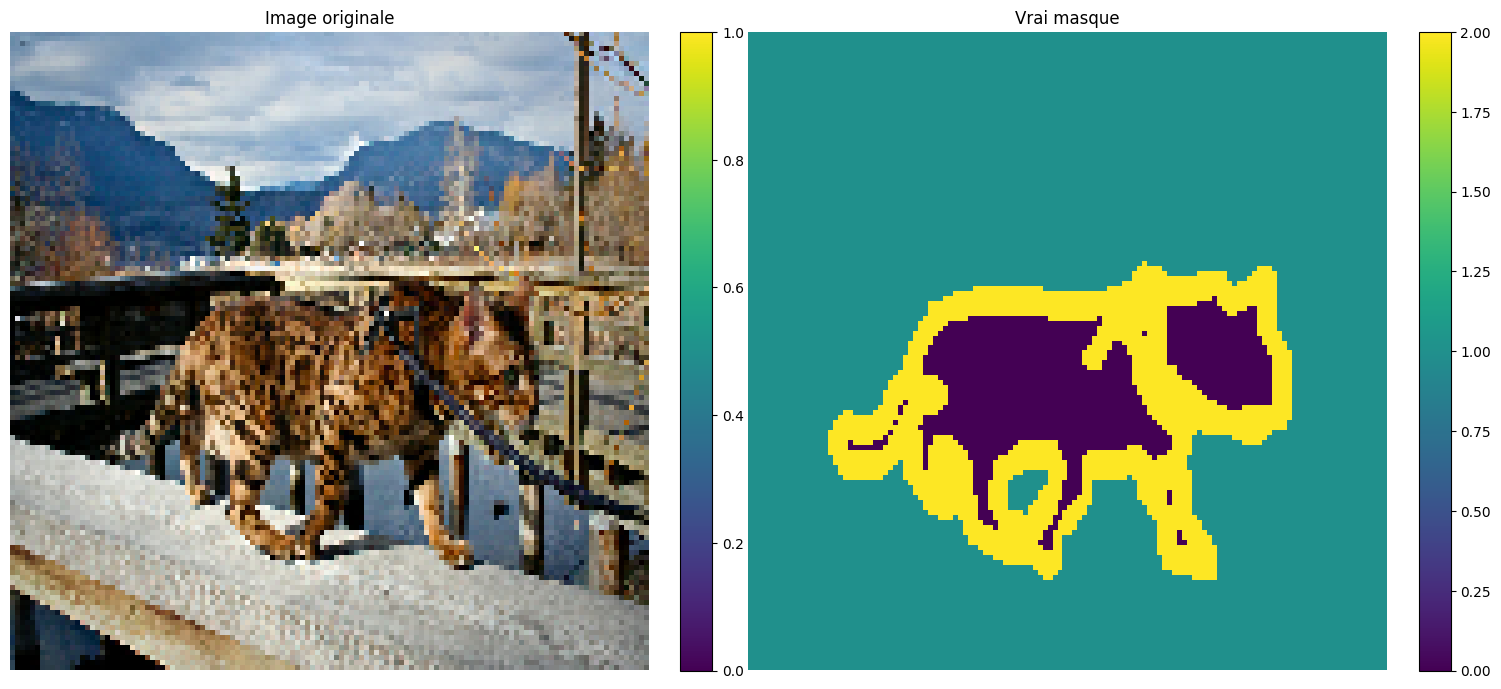

In [15]:
exemple_iter = next(iter(test_batches))
indice_aleatoire = np.random.choice(exemple_iter[0].shape[0])
exemple_image, exemple_mask = exemple_iter[0][indice_aleatoire], exemple_iter[1][indice_aleatoire]
affiche([exemple_image, exemple_mask])

# Construction du modèle U-Net
<a id='construction_modele'></a>

Nous sommes enfin prêts à construire le modèle U-Net. 

L'architecture de notre modèle est la suivante : l'image originale, de taille 128x128x3, passe tout d'abord par une série de convolutions 3x3 et de sous-échantillonnages, puis par des convolutions transposées et concaténations. 

<img src="Segmentation_architecture.png" alt="architecture U-Net" width="800"/>


##  Construction des blocs
Nous définissons tout d'abord des blocs constitutifs du modèle U-Net.

Le premier bloc est constitué de deux couches successives de filtres de convolution, chacun avec ```n_filters``` filtres de taille 3x3, un remplissage permettant de conserver les dimensions, et une fonction d'activation ReLU.

Contrairement au réseau U-Net original, nous utilisons un remplissage afin d'obtenir une images segmentée de la même taille que l'image originale. 

In [16]:
def bloc_double_conv(x, n_filters):
    # Conv2D avec activation ReLU
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
    # Conv2D avec activation ReLU
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
    return x

Le bloc suivant associe convolution et sous-échantillonnage. 

Il contient tout d'abord un bloc convolutif défini dans la fonction précédente, puis une agrégation par maximum, puis une extinction de neurones.

La fonction retourne à la fois la sortie du bloc convolutif, qui sera concaténée aux sorties de la seconde partie du réseau, et la sortie du bloc d'extinction de neurones. 

Ce sont ces blocs qui constituent la partie de contraction de notre réseau. 

In [17]:
def bloc_sous_enchantillonnage(x, n_filters):
    # Bloc convolutif
    f = bloc_double_conv(x, n_filters)
    # Agrégation par maximum
    p = layers.MaxPool2D(2)(f)
    # Extinction de neurones
    p = layers.Dropout(0.3)(p)

    return f, p

Le dernier bloc commence par une couche de convolution transposée avec ```n_filters``` de taille 3x3, qui permet de doubler la taille de l'image d'entrée. La sortie de cette couche est ensuite concaténée avec les caractéristiques issues de la première partie du réseau, donnée dans l'argument d'entrée de la fonction ```conv_features```. 

Ce bloc contient ensuite une couche d'extinction de neurones, puis un bloc convolutif. 

Ce bloc sera utilisé dans la partie expansion de notre réseau. 

In [18]:
def bloc_sur_enchantillonnage(x, conv_features, n_filters):
    # Sur échantillonnage
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # Concatenate
    x = layers.concatenate([x, conv_features])
    # Extinction de neurones
    x = layers.Dropout(0.3)(x)
    # Bloc convolutif
    x = bloc_double_conv(x, n_filters)

    return x

## Construction du modèle U-Net à partir des blocs

La fonction suivante permet de construire le modèle U-Net à partir des blocs définis plus haut. 

In [19]:
def construire_unet():

    # Entrées de taille 128x128x3
    inputs = layers.Input(shape=(128,128,3))

    # Première partie du réseau : contraction
    # Sous-échantillonnage avec 64 filtres
    f1, p1 = bloc_sous_enchantillonnage(inputs, 64)
    # Sous-échantillonnage avec 128 filtres
    f2, p2 = bloc_sous_enchantillonnage(p1, 128)
    # Sous-échantillonnage avec 256 filtres
    f3, p3 = bloc_sous_enchantillonnage(p2, 256)
    # Sous-échantillonnage avec 512 filtres
    f4, p4 = bloc_sous_enchantillonnage(p3, 512)

    # Liaison entre la partie de contraction et la partie d'expansion
    liaison = bloc_double_conv(p4, 1024)

    # Seconde partie du réseau :expansion et concaténation avec la partie de contraction
    # Sur-échantillonnage avec 512 filtres et concaténation avec f4
    u6 = bloc_sur_enchantillonnage(liaison, f4, 512)
    # Sur-échantillonnage avec 256 filtres et concaténation avec f3
    u7 = bloc_sur_enchantillonnage(u6, f3, 256)
    # Sur-échantillonnage avec 128 filtres et concaténation avec f2
    u8 = bloc_sur_enchantillonnage(u7, f2, 128)
    # Sur-échantillonnage avec 64 filtres et concaténation avec f1
    u9 = bloc_sur_enchantillonnage(u8, f1, 64)

    # La dernière couche de convolution contient 3 filtres (pour prédire 3 classes) de taille 1x1
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # Création du modèle avec l'API de Keras
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [20]:
modele_unet = construire_unet()

Nous pouvons afficher un résumé de l'architecture du modèle. 

In [21]:
modele_unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Compilation et entraînement
<a id='entrainement_modele'></a>

Il est nécessaire de compiler le modèle avant de l'entraîner. Lors de la compilation, nous spécifions : 
- La fonction d'optimisation : Adam ;
- La fonction-coût : l'entropie croisée catégorielle ;
- La métrique à surveiller : la justesse. 

In [22]:
modele_unet.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

Il est maintenant possible de spécifier les dernier paramètres et lancer l'entraînement. 

Puisque nous avons généré nos lots avec une taille infinie (en appelant la fonction ```repeat``` sans spécifier de nombre de répétitions), il est indispensable de définir le nombre d'étapes à réaliser :
- Le nombre d'époques, ```nb_epoques```. Ici, nous choisissons d'itérer pendant 20 époques ;
- Le nombre d'images d'entraînement à utiliser par époque, ```nb_images_train_par_epoque```: lorsque le nombre d'images dans l'ensemble d'entraînement est connu, ce nombre peut en être facilement déduit. Cependant, ici, Keras considère que l'ensemble d'entraînement contient un nombre infini d'images. Il faut donc spécifier le nombre d'itérations par époque. Ce nombre est simplement : 
$\frac{\textrm{Nombre d'images d'entraînement}}{\textrm{taille de lot}}$;
- Le nombre d'images de validation à utiliser par époque, ```nb_images_val_par_epoque```: il se calcule de la même manière que ```nb_images_train_par_epoque```.

In [24]:
nb_epoques = 20

nb_images_train = info.splits["train"].num_examples
nb_images_train_par_epoque = nb_images_train // taille_lot

nb_images_val_par_epoque = taille_validation // taille_lot

model_history = modele_unet.fit(train_batches,
                                epochs=nb_epoques,
                                steps_per_epoch=nb_images_train_par_epoque,
                                validation_steps=nb_images_val_par_epoque,
                                validation_data=validation_batches)

Epoch 1/20
230/230 [==============================] - 65s 229ms/step - loss: 0.9245 - accuracy: 0.5863 - val_loss: 0.7405 - val_accuracy: 0.6965
Epoch 2/20
230/230 [==============================] - 53s 232ms/step - loss: 0.6921 - accuracy: 0.7130 - val_loss: 0.6700 - val_accuracy: 0.7288
Epoch 3/20
230/230 [==============================] - 54s 236ms/step - loss: 0.6285 - accuracy: 0.7479 - val_loss: 0.6238 - val_accuracy: 0.7541
Epoch 4/20
230/230 [==============================] - 56s 245ms/step - loss: 0.5480 - accuracy: 0.7848 - val_loss: 0.4918 - val_accuracy: 0.8086
Epoch 5/20
230/230 [==============================] - 61s 264ms/step - loss: 0.5011 - accuracy: 0.8052 - val_loss: 0.4502 - val_accuracy: 0.8286
Epoch 6/20
230/230 [==============================] - 64s 276ms/step - loss: 0.4703 - accuracy: 0.8176 - val_loss: 0.4357 - val_accuracy: 0.8330
Epoch 7/20
230/230 [==============================] - 67s 290ms/step - loss: 0.4272 - accuracy: 0.8348 - val_loss: 0.4759 - val_ac

## Affichage de la courbe d'entraînement

A partir du dictionnaire ```model_history``` rempli lors de l'entraînement du modèle, nous pouvons tracer la justesse et la valeur de la fonction-coût en fonction des itérations pour les données d'entraînement et de test. 

In [25]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(nb_epoques)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(range(nb_epoques), acc, label="Justesse (entraînement)")
    plt.plot(range(nb_epoques), val_acc, label="Justesse (validation)")
    plt.title("Justesse")
    plt.xlabel("Epoque")
    plt.ylabel("Justesse")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(range(nb_epoques), loss, label="Fonction coût (entraînement)")
    plt.plot(range(nb_epoques), val_loss, label="Fonction coût (validataion)")
    plt.title("Fonction coût")
    plt.xlabel("Epoque")
    plt.ylabel("Fonction coût")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

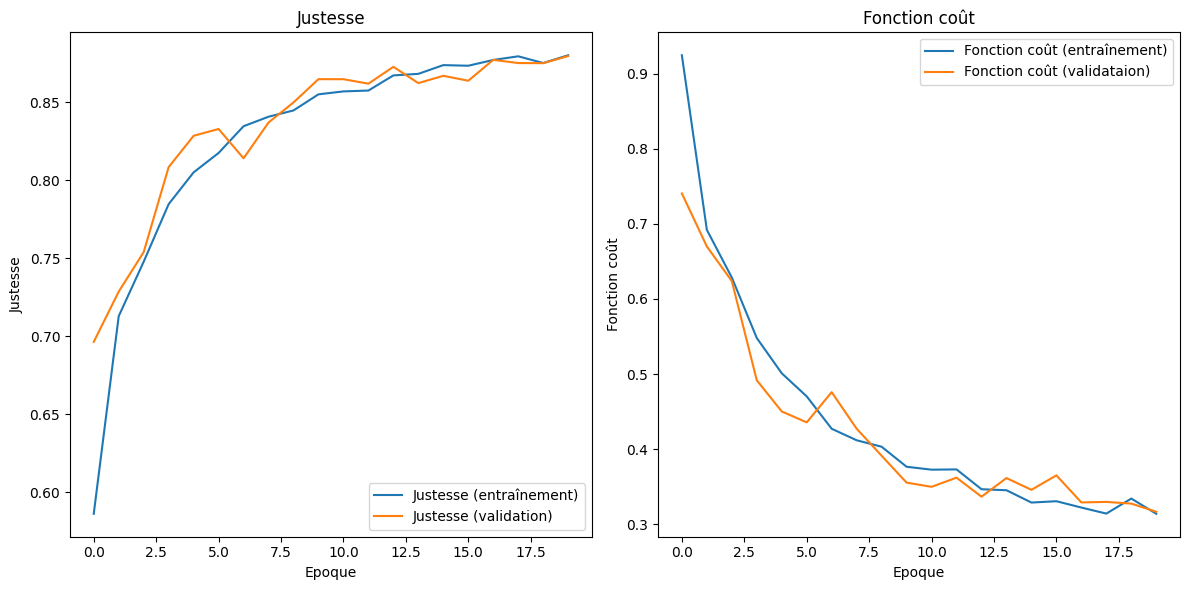

In [27]:
display_learning_curves(modele_unet.history)

Le modèle affiche des performances correctes à la fois sur les données d'entraînement et de validation : il parvient à généraliser, sans surapprentissage. 


# Application du modèle
<a id='application'></a>
Appliquons maintenant le modèle entraîné à plusieurs images de l'ensemble de données de test. 

La fonction ```affiche_predictions``` prend en entrée un modèle de segmentation entraîné, ```modele```, un jeu de données ```dataset```, et un nombre, ```nb_images```. 

Elle applique le modèle ```modele``` aux ```nb_images``` premières images de ```dataset```

In [53]:
def affiche_predictions(modele, dataset, nb_images=1):
    for image, masque in dataset.take(nb_images):
        # Calcul de la prédiction du modèle
        segmentation_predite = modele.predict(image)
        
        # La carte de segmentation renvoyée par le modèle comprend autant de canaux que de classes d'intérêt. 
        # On convertit cette image en une image à un seul canal, celui de la classe la plus probable. 
        segmentation_predite = tf.argmax(segmentation_predite, axis=-1)

        # Les variables 'image' et 'masque' correspondent à un lot      
        # Nous affichons l'image, le vrai masque et le masque prédit de la première image du lot uniquement
        affiche([image[0], masque[0], segmentation_predite[0]])

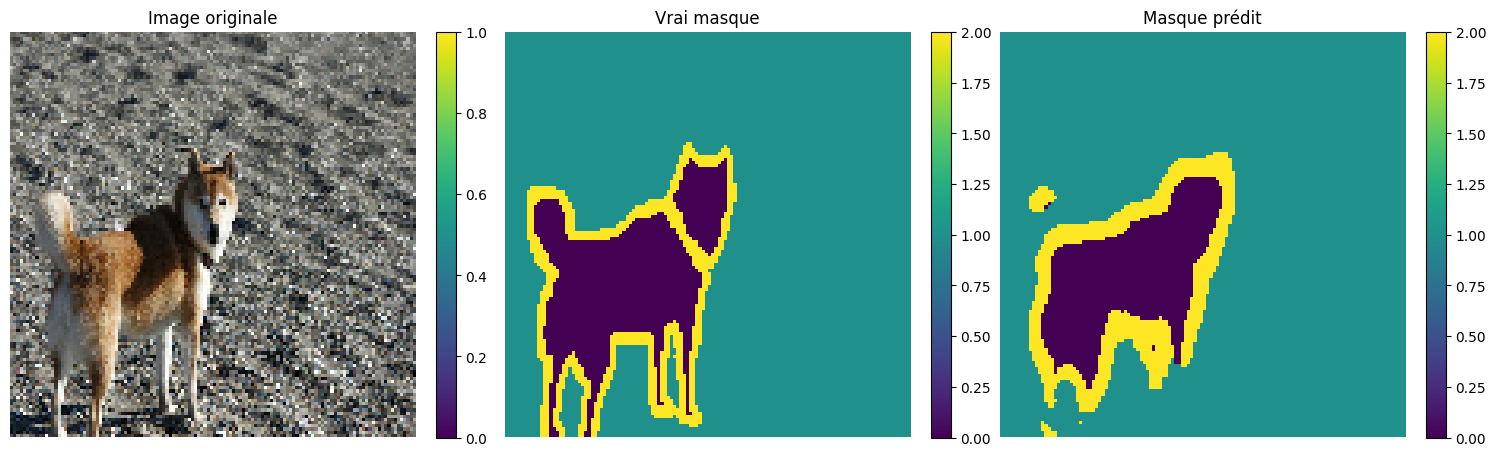

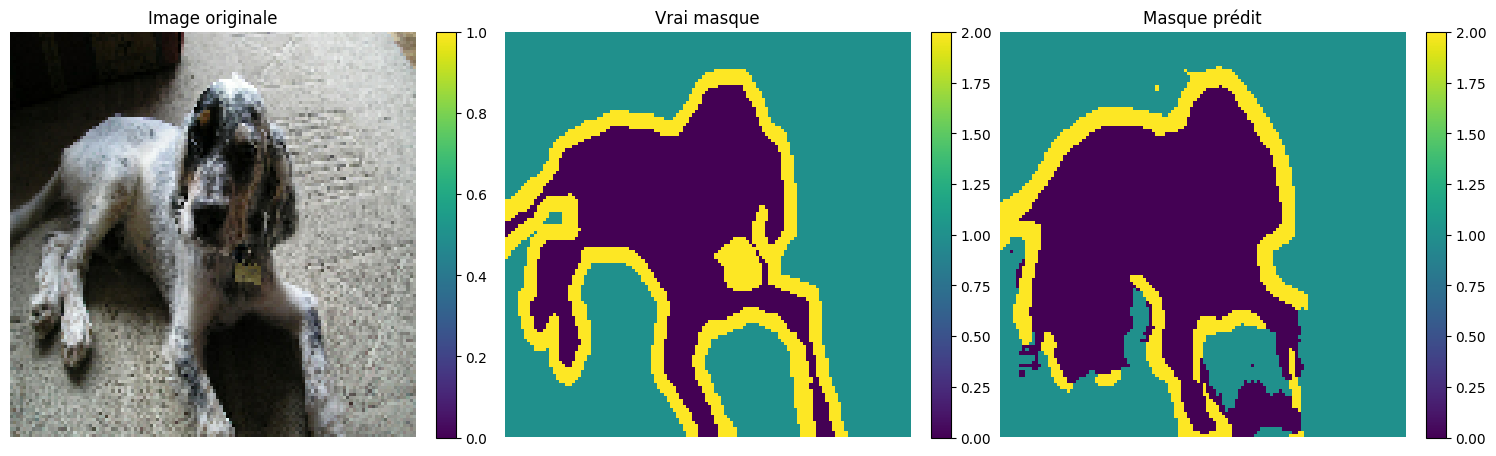

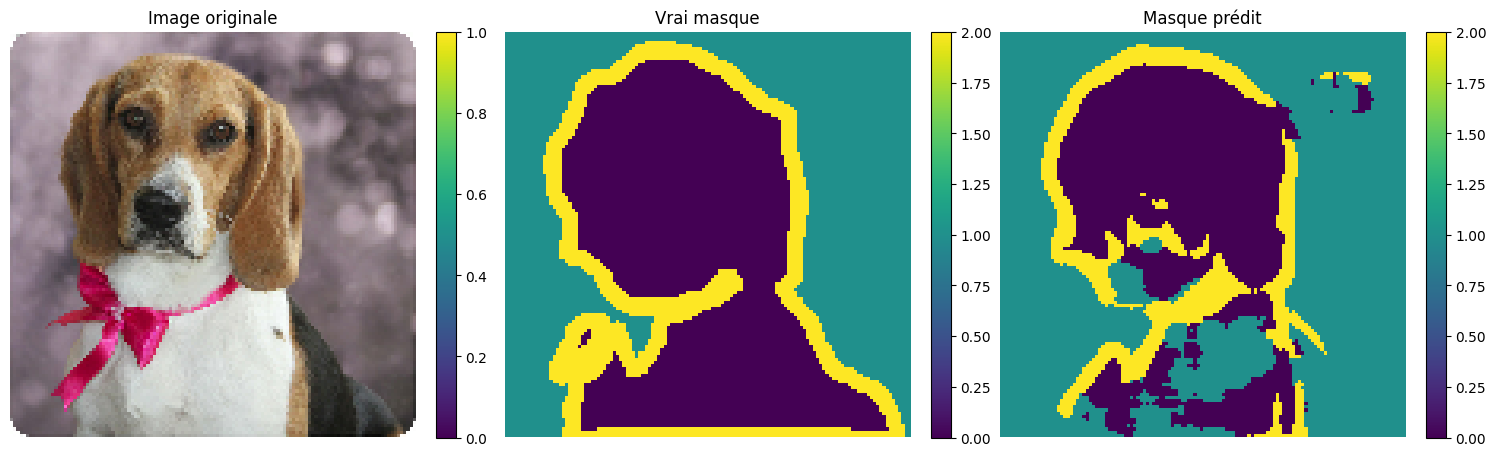

In [54]:
affiche_predictions(modele_unet, test_batches.skip(5), 3)

# A vous de jouer
<a id='avousdejouer'></a>

A vous de jouer maintenant pour essayer d'améliorer encore la performance du modèle. Voici quelques pistes : 
- Augmenter la taille de lot ;
- Modifier le taux d'entraînement (ici, c'est la valeur par défaut, 0.001, qui a été utilisée) ;
- Augmenter le nombre d'itérations ;
- Augmenter la résolution des images d'entrée ;
- Etc. 